## Clasificación multiclase

Cuando tenemos un dataset con más de 2 clases se trata de un problema multiclase.

Por ejemplo:

* Predecir la especie de una flor en iris: 3 posibilidades
* Predecir la especie de un penguin: 3 posibilidades
* Predecir qué número hay en una imagen de 0 a 9: 10 posibilidades

En la **versión multinomial o multiclase**, en lugar de una sola salida entre 0 y 1, necesitamos una **probabilidad** para cada clase (por ejemplo, 3 clases → 3 probabilidades que sumen 1). Para ello, se usa la **función softmax**.

Para cada clase $k$ calculamos un valor $z_k$ (una combinación lineal de tus variables con un vector de pesos para cada clase). Por ejemplo, si tienes 3 clases (A, B, C), tendrás:

$$
z_A = w_{A0} + w_{A1}x_1 + w_{A2}x_2 + \dots
$$
$$
z_B = w_{B0} + w_{B1}x_1 + w_{B2}x_2 + \dots
$$
$$
z_C = w_{C0} + w_{C1}x_1 + w_{C2}x_2 + \dots
$$

La **función softmax** convierte $(z_A, z_B, z_C)$ en probabilidades $(P_A, P_B, P_C)$ que suman 1:

$$
P_A = \frac{e^{z_A}}{e^{z_A} + e^{z_B} + e^{z_C}}, \quad
P_B = \frac{e^{z_B}}{e^{z_A} + e^{z_B} + e^{z_C}}, \quad
P_C = \frac{e^{z_C}}{e^{z_A} + e^{z_B} + e^{z_C}}
$$

En general, para $K$ clases:
$$
P_k = \frac{e^{z_k}}{\sum_{j=1}^{K} e^{z_j}}
$$

Cada $P_k$ es la probabilidad de pertenecer a la clase $k$, y **todas** las $P_k$ juntas suman 1.

Parámetro para metrics como f1, precision, recall

* macro: cuando el dataset está balanceado o todas las clases tienen igual importancia
    * das el mismo peso a cada división 'primera', 'segunda', 'tercera', 'no asciende'
* micro: desempeño global general, problemas desbalanceados donde el tamaño total importa
    * si no importa las divisiones en sí, e importa a nivel de todas las precciones independientemente de las clases
* weighted: cuando está desbalanceado y queremos tener en cuenta el tamaño de cada clase.
    * cuando hay divisiones más grandes que otras queremos reflejar el desbalance real del torneo

https://es.besoccer.com/partido/alaves/celta/20256522/clasificacion

Ver balanceo:
* sns.countplot()

* X: los datos tienen que ser numéricos
* y: suele ser habitual convertir a numéricos usando .map o LabelEncoder, pero se pueden mantener así

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

In [58]:
df = sns.load_dataset('iris')
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


<Axes: xlabel='species', ylabel='count'>

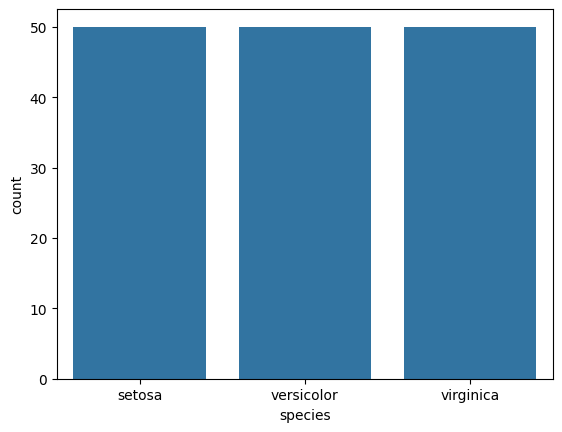

In [59]:
# Clases balanceadas, mismo número de registros de cada especie
sns.countplot(df, x='species')

In [60]:
from sklearn.model_selection import train_test_split

X = df.drop('species', axis=1)
y = df['species'].map({'setosa': 0, 'versicolor': 1, 'virginica': 2})
# y = df['species']

# Particionamiento normal: vemos que puede tomar distinto número de registros de cada clase, generando un ligero "desbalanceo"
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print(y_train.value_counts())
print(y_test.value_counts())

species
versicolor    41
setosa        40
virginica     39
Name: count, dtype: int64
species
virginica     11
setosa        10
versicolor     9
Name: count, dtype: int64


## stratify:

asegura que la división sea proporcionar en función del a variable objetivo (species). SE tiene mantener esa proporción tanto en entrenamiento como en test.

* Si no usamos stratify la división es aleatorio. 
* Si usamos stratify se sasegura de que la proporción de clases en el conjunto de datos original se refleje en los conjuntos de train y test.

Ideal para problemas de clasificación, en regresión se puede tener en cuenta si hay columnas categóricas.

In [61]:
# Particionamiento con stratify: le pasamos la columna y en stratify para asegurar el mismo número de registro de cada clase 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
print(y_train.value_counts()) # 40 registros de cada specie equivale al 80 % de 50 registros
print(y_test.value_counts()) # 10 registros de cada specie equivale al 20 % de 50 registros

species
setosa        40
virginica     40
versicolor    40
Name: count, dtype: int64
species
setosa        10
virginica     10
versicolor    10
Name: count, dtype: int64


In [62]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

df_resultados = pd.DataFrame(columns=['Modelo', 'accuracy', 'precision', 'recall', 'f1', 'AUC'])

def calculate_metrics(name, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    # OVR: One vs Rest calcula AUC para cada clase de manera individual, considerando cada clase como positiva y las demás como negativas
    # OVO: One vs One calcula el AUC para cada par de clases, combina resultados calculando promedio según métrica average
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
    
    df_resultados.loc[len(df_resultados)] = [name, accuracy, precision, recall, f1, auc]

## Regresión logística

En vez de usar la función sigmoide que se usa para clasificación binaria, en problemas de clasificación multiclase se usa una función softmax, genera una probabilidad para cada clase de modo que todas sumen 1.

In [63]:
model = LogisticRegression(max_iter=500)
calculate_metrics('Rlog', model)
df_resultados

,Modelo,accuracy,precision,recall,f1,AUC
0,Rlog,0.966667,0.969697,0.966667,0.966583,1.0


In [64]:
# KNN 
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
calculate_metrics('KNN 5', model)
df_resultados

,Modelo,accuracy,precision,recall,f1,AUC
0,Rlog,0.966667,0.969697,0.966667,0.966583,1.0
1,KNN 5,1.000000,1.000000,1.000000,1.000000,1.0


In [65]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
calculate_metrics('DT', model)
df_resultados

,Modelo,accuracy,precision,recall,f1,AUC
0,Rlog,0.966667,0.969697,0.966667,0.966583,1.000
1,KNN 5,1.000000,1.000000,1.000000,1.000000,1.000
2,DT,0.966667,0.969697,0.966667,0.966583,0.975


In [66]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
calculate_metrics('RF', model)
df_resultados

,Modelo,accuracy,precision,recall,f1,AUC
0,Rlog,0.966667,0.969697,0.966667,0.966583,1.000000
1,KNN 5,1.000000,1.000000,1.000000,1.000000,1.000000
2,DT,0.966667,0.969697,0.966667,0.966583,0.975000
3,RF,0.933333,0.933333,0.933333,0.933333,0.986667


In [75]:
from sklearn.svm import SVC

# probability = True para poder usar predict_proba y calcular AUC
model = SVC(probability=True)
calculate_metrics('SVC', model)
df_resultados

,Modelo,accuracy,precision,recall,f1,AUC
0,Rlog,0.966667,0.969697,0.966667,0.966583,1.000000
1,KNN 5,1.000000,1.000000,1.000000,1.000000,1.000000
2,DT,0.966667,0.969697,0.966667,0.966583,0.975000
3,RF,0.933333,0.933333,0.933333,0.933333,0.986667
4,SVC,0.966667,0.969697,0.966667,0.966583,0.996667


In [74]:
# Alternativa sin probability = True, se usa decision_function en lugar de predict_proba, más rápido
model = SVC()
model.fit(X_train, y_train)
y_pred = model.decision_function(X_test)
roc_auc_score(pd.get_dummies(y_test), y_pred, multi_class='ovr')

np.float64(0.9933333333333333)

In [ ]:
# probar penguins, clasificación multiclase columna specie o island